## Восстановление баллистической траектории по траекторным измерениям (участку траектории) 
### * входные данные участок траектории [t(с), x(м), y(м)], шаг 2 с
### * выходные данные вся траектория [t(с), x(м), y(м), z(м)], шаг 1 с

In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
# Пример считывания данных из файла с траекториями
trj = pd.read_csv("trajectories/Траектория ОФ29 угол = 0.txt", sep=" ", decimal = ",")
# Функция удаления столбца со всеми значениями NaN
# Типы входных данных: 
# trj - pandas.DataFrame
# Тип выходных данных: 
# pandas.DataFrame
def clear_nan_col(trj):
    col_nan = []
    for ncol in trj.columns:
        if trj[ncol].isnull().all():
            col_nan.append(ncol)
    return(trj.drop(col_nan, axis=1))
trj = clear_nan_col(trj)
trj

,t(c),x(м),y(м),z(м),Vk(м/с),teta(град),psy(град),omega_x(рад/с),pi(y),m(кг)
0,0.000,0.0000,1.0000,0.0000,945.0000,0.0000,0.0000,1562.5290,0.9741,46.0
1,0.050,47.1848,0.9880,0.0007,942.3947,-0.0293,-0.0018,1561.8376,0.9741,46.0
2,0.100,94.2396,0.9519,0.0030,939.7981,-0.0586,-0.0036,1561.1471,0.9741,46.0
3,0.150,141.1647,0.8918,0.0067,937.2099,-0.0880,-0.0055,1560.4574,0.9741,46.0
4,0.200,187.9606,0.8079,0.0119,934.6303,-0.1176,-0.0073,1559.7686,0.9742,46.0
5,0.250,234.6277,0.7001,0.0186,932.0592,-0.1471,-0.0091,1559.0807,0.9742,46.0
6,0.300,281.1664,0.5685,0.0268,929.4966,-0.1768,-0.0110,1558.3936,0.9742,46.0
7,0.350,327.5771,0.4133,0.0364,926.9423,-0.2066,-0.0128,1557.7074,0.9742,46.0
8,0.400,373.8601,0.2343,0.0475,924.3965,-0.2364,-0.0146,1557.0220,0.9742,46.0
9,0.450,420.0161,0.0318,0.0600,921.8590,-0.2664,-0.0165,1556.3374,0.9742,46.0


In [3]:
# Функции нормализации исходных данных
# data - DataFrame
# min_max - dictionary
# { key  : 't(c)'
#   value : [0, 150] ## 
# }
def code(data, min_max):
    for d in data.values():
        for k in d.columns:
           if k in min_max.keys():
               d[k] = (d[k] - min_max[k][0])/(min_max[k][1] - min_max[k][0]);
    return data
def decode(data, min_max):
    for d in data.values():
        for k in d.columns:
           if k in min_max.keys():
               d[k] = d[k]*(min_max[k][1] - min_max[k][0]) + min_max[k][0];
    return data
#mm = {'t(c)': [0.0, 150.0], 'x(м)': [0.0, 30000.0], 'y(м)':[0.0, 10000.0]}
#code([trj,],   mm)
#decode([trj,], mm)

In [4]:
# Считывание всех траекторий
path_dir = 'trajectories'
trj_dict = {}
for fname in os.listdir(path_dir):
    path_file = path_dir + '/' +fname
    trj = pd.read_csv(path_file, sep=" ", decimal = ",")
    trj = clear_nan_col(trj)
    if (trj['t(c)'].iloc[-1]>20):
        trj_dict[path_file] =  trj
len(trj_dict)

52

In [5]:
# Предобработка траекторий
trj_dict_proc = {}
col_list = ['t(c)', 'x(м)', 'y(м)', 'z(м)']
# Анализ траекторий, определяем максимальное число строк
max_rows = max( [v.shape[0]  for v in trj_dict.values()])
# максимальное количество элемнентов
max_rows = 110
print(max_rows)
# Функция выравнивания размеров траекторий до max_rows
# method in {"by_zeros", "by_last"}
def max_rows_set(trj, max_rows, method = "by_zeros"):
    col_list = trj.columns
    rows_count = trj.shape[0]
    append_rows = max_rows - rows_count
    if (method == "by_last"):
        time_last = np.floor(trj[trj.columns[0]].iloc[-1])
        trj_last = trj.tail(1).copy()
        for j in range(rows_count, max_rows):
            time_last = time_last + 1.0;
            trj_last[trj.columns[0]].iloc[-1] = time_last;
            trj_last.index = trj_last.index + 1
            trj = pd.concat([trj, trj_last.copy()])
    else:
        df_zeros = pd.DataFrame(np.zeros([append_rows, len(col_list)]), 
                                index = range(rows_count, max_rows), 
                                columns = col_list)
        trj = pd.concat([trj, df_zeros])
    return trj
# Создаем новый набор траекторий
# Приводим размер траекторий к max_rows    
for k in trj_dict.keys():
    trj_dict_proc[k] = max_rows_set(trj_dict[k].copy()[col_list], max_rows, method = "by_last")
len(trj_dict_proc)

110


52

In [6]:
# Нормализация данных
mm = {'t(c)': [0.0, 200.0], 'x(м)': [0.0, 30000.0], 'y(м)':[0.0, 10000.0], 'z(м)':[0.0, 1000.0]}
trj_dict_proc = code(trj_dict_proc, mm)

In [7]:
# Создание массива данных
x_data = np.array([x for x in trj_dict_proc.values() ]).astype("float32")
n = len(x_data)

#x_train = x_data[range(0, n, 2)]
x_train = []
y_train = []
for x in x_data[range(0, n, 2)]:
    x_new = np.delete(x, obj = 3, axis = 1)
    x_rows = x_new.shape[0]
    for k in range(0, x_rows-20):
        x_tr = x_new[range(k,k+20,2)]
        if(x_tr[-1,-1] !=  x_tr[-2,-1]):
            x_train.append(x_tr.copy()) 
            y_train.append(x.copy())
x_train = np.array(x_train)
y_train = np.array(y_train)

x_test = []
y_test = []
for x in x_data[range(1, n, 2)]:
    x_new = np.delete(x, obj = 3, axis = 1)
    x_rows = x_new.shape[0]
    for k in range(0, x_rows-20):
        x_tr = x_new[range(k,k+20,2)]
        if(x_tr[-1,-1] !=  x_tr[-2,-1]):
            x_test.append(x_tr.copy()) 
            y_test.append(x.copy())
x_test = np.array(x_test)
y_test = np.array(y_test)
print(x_train.shape[0])
print(x_test.shape[0])

1347
1303


In [8]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

TensorFlow version: 2.13.0


In [10]:
model = models.Sequential()
model.add(layers.Conv1D(64, kernel_size=3, activation='relu', padding='same', input_shape=(10, 3)))
# model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, kernel_size=3,  activation='relu', padding='same'))
# model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1DTranspose(32, kernel_size=3, strides= 11, activation='relu', padding='same') )
model.add(layers.Conv1DTranspose(64, kernel_size=3, activation='relu', padding='same') )
model.add(layers.Conv1D(4, kernel_size=3, activation='relu', padding='same'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 10, 64)            640       
                                                                 
 conv1d_4 (Conv1D)           (None, 10, 32)            6176      
                                                                 
 conv1d_transpose_2 (Conv1D  (None, 110, 32)           3104      
 Transpose)                                                      
                                                                 
 conv1d_transpose_3 (Conv1D  (None, 110, 64)           6208      
 Transpose)                                                      
                                                                 
 conv1d_5 (Conv1D)           (None, 110, 4)            772       
                                                                 
Total params: 16900 (66.02 KB)
Trainable params: 16900

In [11]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mse'])

history = model.fit(x_train, y_train, epochs=200, verbose = 1, 
                    validation_data=(x_test, y_test))

Epoch 1/200
43/43 [==============================] - 1s 15ms/step - loss: 0.1372 - mse: 0.1372 - val_loss: 0.0773 - val_mse: 0.0773
Epoch 2/200
43/43 [==============================] - 0s 12ms/step - loss: 0.0723 - mse: 0.0723 - val_loss: 0.0614 - val_mse: 0.0614
Epoch 3/200
43/43 [==============================] - 0s 11ms/step - loss: 0.0569 - mse: 0.0569 - val_loss: 0.0502 - val_mse: 0.0502
Epoch 4/200
43/43 [==============================] - 0s 10ms/step - loss: 0.0491 - mse: 0.0491 - val_loss: 0.0458 - val_mse: 0.0458
Epoch 5/200
43/43 [==============================] - 0s 11ms/step - loss: 0.0459 - mse: 0.0459 - val_loss: 0.0440 - val_mse: 0.0440
Epoch 6/200
43/43 [==============================] - 0s 11ms/step - loss: 0.0446 - mse: 0.0446 - val_loss: 0.0431 - val_mse: 0.0431
Epoch 7/200
43/43 [==============================] - 0s 11ms/step - loss: 0.0440 - mse: 0.0440 - val_loss: 0.0428 - val_mse: 0.0428
Epoch 8/200
43/43 [==============================] - 0s 11ms/step - loss: 0.

41/41 - 0s - loss: 0.0409 - mse: 0.0409 - 126ms/epoch - 3ms/step


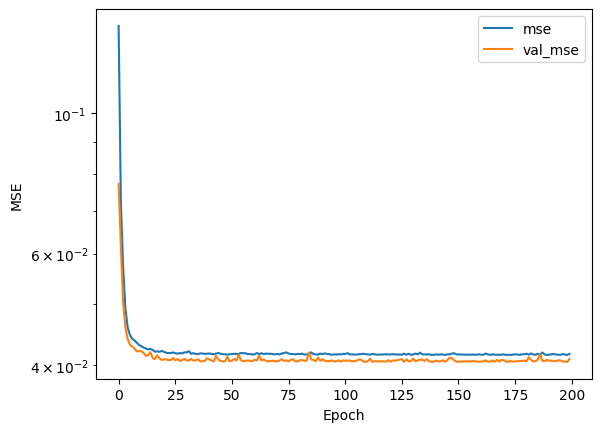

In [12]:
plt.plot(history.history['mse'], label='mse')
plt.plot(history.history['val_mse'], label = 'val_mse')
plt.yscale("log")
plt.xlabel('Epoch')
plt.ylabel('MSE')
#plt.ylim([0.0, 0.15])
plt.legend(loc='upper right')

test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

In [13]:
x_pred = model.predict(x_test, verbose=2)
df_pred = [ (i, pd.DataFrame(x_pred[i], columns = col_list) ) for i in range(len(x_pred))] 
df_pred = dict(df_pred)
df_pred = decode(df_pred, mm)

df_test = [ (i, pd.DataFrame(x_test[i], columns = col_list[:-1]) ) for i in range(len(x_test))] 
df_test = dict(df_test)
df_test = decode(df_test, mm)


41/41 - 0s - 279ms/epoch - 7ms/step


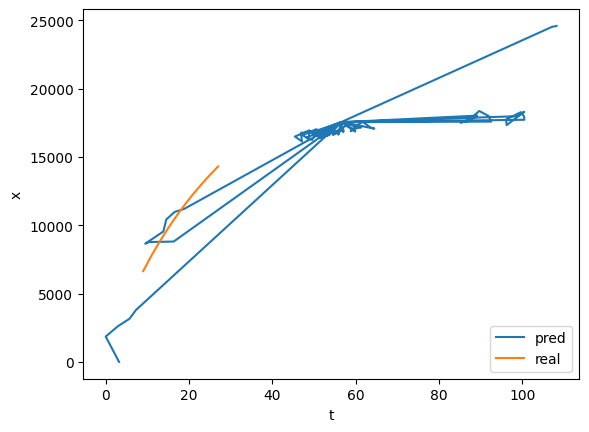

In [14]:
k = 20
plt.plot(df_pred[k][col_list[0]], df_pred[k][col_list[1]], label='pred')
plt.plot(df_test[k][col_list[0]], df_test[k][col_list[1]], label='real')
plt.xlabel('t')
plt.ylabel('x')
#plt.ylim([0.0, 0.15])
plt.legend(loc='lower right')
plt.show()

In [ ]:
k = 20
plt.plot(df_pred[k][col_list[0]], df_pred[k][col_list[1]] - df_test[k][col_list[1]])
plt.xlabel('t')
plt.ylabel('delta x')
#plt.ylim([0.0, 0.15])
plt.show()

In [ ]:
k = 20
plt.plot(df_pred[k][col_list[0]], df_pred[k][col_list[2]], label='pred')
plt.plot(df_test[k][col_list[0]], df_test[k][col_list[2]], label='real')
plt.xlabel('t')
plt.ylabel('y')
#plt.ylim([0.0, 0.15])
plt.legend(loc='upper right')
plt.show()

In [ ]:
k = 20
plt.plot(df_pred[k][col_list[0]], df_pred[k][col_list[2]] - df_test[k][col_list[2]])
plt.xlabel('t')
plt.ylabel('delta y')
#plt.ylim([0.0, 0.15])
plt.show()

In [ ]:
k = 20
plt.plot(df_pred[k][col_list[0]], df_pred[k][col_list[3]], label='pred')
#plt.plot(df_test[k][col_list[0]], df_test[k][col_list[3]], label='real')
plt.xlabel('t')
plt.ylabel('z')
#plt.ylim([0.0, 0.15])
plt.legend(loc='lower right')
plt.show()

In [ ]:
k = 20
plt.plot(df_pred[k][col_list[1]], df_pred[k][col_list[2]], label='pred')
plt.plot(df_test[k][col_list[1]], df_test[k][col_list[2]], label='real')
plt.xlabel('x')
plt.ylabel('y')
#plt.ylim([0.0, 0.15])
plt.legend(loc='upper right')
plt.show()

In [ ]:
k = 20
plt.plot(df_pred[k][col_list[1]], df_pred[k][col_list[2]] - df_test[k][col_list[2]], label='pred')
plt.xlabel('x')
plt.ylabel('delta y')
#plt.ylim([0.0, 0.15])
plt.show()

In [ ]:
k = 20
plt.plot(df_pred[k][col_list[1]], df_pred[k][col_list[3]], label='pred')
#plt.plot(df_test[k][col_list[1]], df_test[k][col_list[3]], label='real')
plt.xlabel('x')
plt.ylabel('z')
#plt.ylim([0.0, 0.15])
plt.legend(loc='lower right')
plt.show()